### Import Module

In [55]:
import re

import pandas as pd
import numpy as np

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from nltk import word_tokenize
from nltk.corpus import stopwords

from gensim.models import Word2Vec
from gensim.models import Doc2Vec

import tensorflow as tf

import matplotlib.pyplot as plt

### Read Data
- Data Preprocessing
- Tokenize

In [56]:
radio_text = pd.read_csv('./finished_dataset/radio_text.tsv', sep='\t', index_col='patent_id')
#radio_4_ipc = pd.read_csv('./finished_dataset/ra')
# radoo_9_ipc = pd.read_csv
obesity_text = pd.read_csv('./finished_dataset/obesity_text.tsv', sep='\t', index_col='patent_id')
obesity_4_ipc = pd.read_csv('./finished_dataset/obesity_4ipc.tsv', sep='\t', index_col='patent_id')
obesity_9_ipc = pd.read_csv('./finished_dataset/obesity_9ipc.tsv', sep='\t', index_col='patent_id')
ship_text = pd.read_csv('./finished_dataset/ship_text.tsv', sep='\t', index_col='patent_id')

In [57]:
radio_text['claim'] = radio_text['claim'].str[2:]
obesity_text['claim'] = obesity_text['claim'].str[2:]
ship_text['claim'] = ship_text['claim'].str[2:]

In [58]:
radio_text['claim'] = radio_text['claim'].str.lower().apply(word_tokenize)
radio_text['abstract'] = radio_text['abstract'].str.lower().apply(word_tokenize)
radio_text['title'] = radio_text['title'].str.lower().apply(word_tokenize)

obesity_text['claim'] = obesity_text['claim'].str.lower().apply(word_tokenize)
obesity_text['abstract'] = obesity_text['abstract'].str.lower().apply(word_tokenize)
obesity_text['title'] = obesity_text['title'].str.lower().apply(word_tokenize)

ship_text['claim'] = ship_text['claim'].str.lower().apply(word_tokenize)
ship_text['abstract'] = ship_text['abstract'].str.lower().apply(word_tokenize)
ship_text['title'] = ship_text['title'].str.lower().apply(word_tokenize)

In [59]:
# Change Class (obesity : 1, radio : 2)
obesity_text['subclass'] = obesity_text['class']
radio_text['subclass'] = radio_text['class']
ship_text['subclass'] = ship_text['class']

obesity_text['class'] = 1
radio_text['class'] = 2
ship_text['class'] = 3

In [94]:
print('Obesity')
print(obesity_text['subclass'].value_counts())

print('='*70)
print('Radio')
print(radio_text['subclass'].value_counts())

print('='*70)
print('Ship')
print(ship_text['subclass'].value_counts())

Obesity
1BD    57
1AB    28
1BB    22
1BA    19
1AA    13
1BC     9
Name: subclass, dtype: int64
Radio
2AD    32
2AC    26
2AB    23
2AA     7
2DB     5
2CA     4
2DA     2
2BA     2
21A     1
2BB     1
2CB     1
Name: subclass, dtype: int64
Ship
AAA    57
ABB    19
ABA     5
ACA     5
AAB     3
Name: subclass, dtype: int64


### Preprocessing
- Delete Stopword

In [61]:
stopword = set(stopwords.words('english'))

In [62]:
stopword = stopword.union({'', ' ', '.', ',', '', '#'})

In [65]:
data_frame = [obesity_text, radio_text, ship_text]
text_list = ['claim', 'abstract', 'title']
p = re.compile('[a-zA-Z]')
n = 0
for df in data_frame:
    for col in text_list:
        df[col] = df[col].apply(lambda text_data :
                                            list(''.join(p.findall(word)) for word in text_data if word not in stopword))
        df[col] = df[col].apply(lambda text_data : [word.strip() for word in text_data if word.strip() != ''])

In [66]:
# class 없는 데이터 삭제
radio_text.drop(5512256, axis=0, inplace=True)

### Word Embedding

In [67]:
obesity_title_word = obesity_text['title'].values
obesity_abstract_word = obesity_text['abstract'].values#.tolist()
obesity_claim_word = obesity_text['claim'].values#.tolist()

radio_title_word = radio_text['title'].values
radio_abstract_word = radio_text['abstract'].values#.tolist()
radio_claim_word = radio_text['claim'].values#.tolist()

ship_title_word = ship_text['title'].values
ship_abstract_word = ship_text['abstract'].values#.tolist()
ship_claim_word = ship_text['claim'].values#.tolist()

In [68]:
obesity_full_text = [title + abstract + claim for title, abstract, claim in zip(obesity_title_word, obesity_abstract_word, obesity_claim_word)]

radio_full_text = [title + abstract + claim for title, abstract, claim in zip(radio_title_word, radio_abstract_word, radio_claim_word)]

ship_full_text = [title + abstract + claim for title, abstract, claim in zip(ship_title_word, ship_abstract_word, ship_claim_word)]

In [69]:
obesity_embedding_model = Word2Vec(obesity_full_text, size=300, window = 3, min_count=2, iter=500, sg=1)
radio_embedding_model = Word2Vec(radio_full_text, size=300, window = 3, min_count=2, iter=500, sg=1)
ship_embedding_model = Word2Vec(ship_full_text, size=300, window = 3, min_count=2, iter=500, sg=1)

In [70]:
# same code : embedding_model['system']
obesity_word_vector = obesity_embedding_model.wv
radio_word_vector = radio_embedding_model.wv
ship_word_vector = ship_embedding_model.wv
#word_vector.word_vec('system')

In [71]:
df_vector_pare = {'obesity': [obesity_text, obesity_word_vector], 'radio':[radio_text, radio_word_vector], 'ship':[ship_text, ship_word_vector]}

for df in df_vector_pare:
    for col in ['title', 'claim', 'abstract']:
        df_vector_pare[df][0][col] = df_vector_pare[df][0][col].apply(lambda text: [df_vector_pare[df][1].word_vec(word) for word in text if word in df_vector_pare[df][1].vocab])
        df_vector_pare[df][0][col] = df_vector_pare[df][0][col].apply(lambda em_vec: [sum(ev) for ev in zip(*em_vec)])

# for col in ['title', 'claim', 'abstract']:
#     obesity[col] = obesity[col].apply(lambda text: [word_vector.word_vec(word) for word in text if word in word_vector.vocab])
#     obesity[col] = obesity[col].apply(lambda em_vec: [sum(ev) for ev in zip(*em_vec)])

In [72]:
df_list = [obesity_text, radio_text, ship_text]

for df in df_list:
    df['title'] = df['title'].apply(lambda x: np.array(x))
    df['claim'] = df['claim'].apply(lambda x: np.asarray(x))
    df['abstract'] = df['abstract'].apply(lambda x: np.asarray(x))

In [16]:
# ob_x = obesity_text['title'].values
# ob_y = obesity_text['claim'].values
# ob_z = obesity_text['abstract'].values

# ra_x = radio_text['title'].values
# ar_y = radio_text['claim'].values
# ar_z = radio_text['abstract'].values

In [73]:
ob_feature = np.array(obesity_text.iloc[:, :-2])
ra_feature = np.array(radio_text.iloc[:, :-2])
sh_feature = np.array(ship_text.iloc[:, :-2])

In [74]:
ob_feature_vec = None
ra_feature_vec = None
sh_feature_vec = None

# obesity feature
for idx, row in enumerate(ob_feature):
    try:
        if ob_feature_vec is None:
            tmp_vec = np.concatenate((row[0], row[1], row[2], row[3:]), axis=0)
            ob_feature_vec = tmp_vec.reshape(1, -1)
        else:
            tmp_vec = np.concatenate((row[0], row[1], row[2], row[3:]), axis=0)
            ob_feature_vec = np.vstack((ob_feature_vec, tmp_vec))
    except:
        print(idx)
        continue

# radio feature
for idx, row in enumerate(ra_feature):
    try:
        if ra_feature_vec is None:
            tmp_vec = np.concatenate((row[0], row[1], row[2], row[3:]), axis=0)
            ra_feature_vec = tmp_vec.reshape(1, -1)
        else:
            tmp_vec = np.concatenate((row[0], row[1], row[2], row[3:]), axis=0)
            ra_feature_vec = np.vstack((ra_feature_vec, tmp_vec))
    except:
        print(idx)
        continue

# ship feature
for idx, row in enumerate(sh_feature):
    try:
        if sh_feature_vec is None:
            tmp_vec = np.concatenate((row[0], row[1], row[2], row[3:]), axis=0)
            sh_feature_vec = tmp_vec.reshape(1, -1)
        else:
            tmp_vec = np.concatenate((row[0], row[1], row[2], row[3:]), axis=0)
            sh_feature_vec = np.vstack((sh_feature_vec, tmp_vec))
    except:
        print(idx)
        continue

In [77]:
# Data merge & shuffle
feature_vec = np.vstack([ob_feature_vec, ra_feature_vec, sh_feature_vec]) # merge (obesity, radio) feature vector 
class_vec = np.vstack([np.array(obesity_text['class']).reshape(-1, 1),
                       np.array(radio_text['class']).reshape(-1, 1),
                       np.array(ship_text['class']).reshape(-1, 1)]) # merge (obesity, radio) class


In [78]:
x_train, x_val, y_train, y_val = train_test_split(feature_vec, class_vec,
                                                  test_size = .2, # 비율 늘리기
                                                  random_state=12)

In [79]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

/Users/jinhong/miniconda3/envs/patent/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jinhong/miniconda3/envs/patent/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [81]:
from mpl_toolkits.mplot3d import Axes3D

color = ['r', 'b', 'g']#, 'g', 'k', 'y', 'm']
le = preprocessing.LabelEncoder()
le.fit(np.unique(y_train))
y_train_n = le.transform(y_train)

#feature_real = np.concatenate((x_train, y_train_n.reshape(len(y_train_n), -1)), axis=1)
feature_real = x_train[:, :900]

from sklearn.manifold import TSNE

model = TSNE(learning_rate=1000, n_components=3)

/Users/jinhong/miniconda3/envs/patent/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [82]:
transformed = model.fit_transform(feature_real)

xs = transformed[:,0]
ys = transformed[:,1]
zs = transformed[:,2]

In [83]:
y_train = y_train.reshape(1, -1)

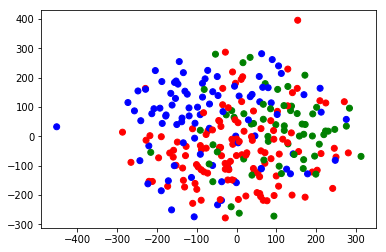

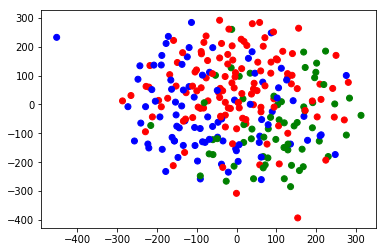

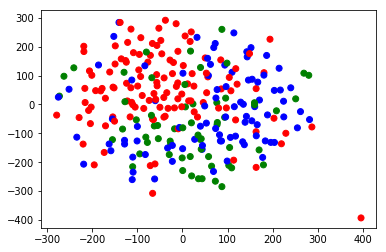

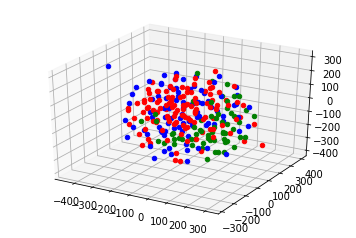

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)

color_list = [color[y-1] for y in y_train[0]]

plt.scatter(xs,ys,c=color_list)

plt.show()

plt.scatter(xs,zs,c=color_list)

plt.show()

plt.scatter(ys,zs,c=color_list)

plt.show()

scatter_data = [xs, ys, zs, y_train_n]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for index in range(len(scatter_data[0])):
    ax.scatter(scatter_data[0][index], scatter_data[1][index], scatter_data[2][index], c=color[scatter_data[3][index]])

plt.show()

In [85]:
# SMOTE 

color = ['r', 'b', 'g']#, 'g', 'k', 'y', 'm']
le = preprocessing.LabelEncoder()
le.fit(np.unique(y_train_res))
y_train_n = le.transform(y_train_res)

feature_fake = x_train_res

transformed = model.fit_transform(feature_fake)

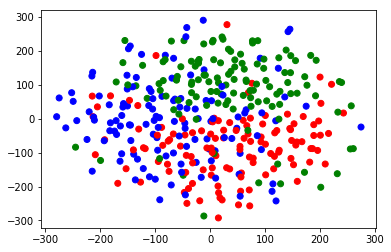

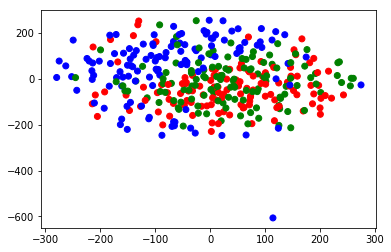

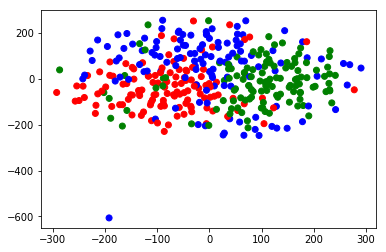

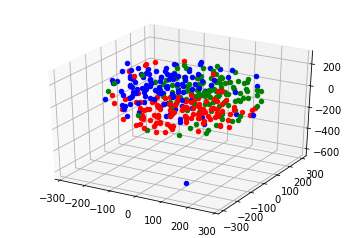

In [86]:
xs = transformed[:,0]
ys = transformed[:,1]
zs = transformed[:,2]

fig = plt.figure()
ax = fig.add_subplot(111)

color_list = [color[y] for y in y_train_n]

plt.scatter(xs,ys,c=color_list)

plt.show()

plt.scatter(xs,zs,c=color_list)

plt.show()

plt.scatter(ys,zs,c=color_list)

plt.show()

scatter_data = [xs, ys, zs, y_train_n]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for index in range(len(scatter_data[0])):
    ax.scatter(scatter_data[0][index], scatter_data[1][index], scatter_data[2][index], c=color[scatter_data[3][index]])

plt.show()

### 1-Depth Classifier

In [87]:
y_one_hot = np.eye(3)[y_train_res-1]
test_y_one_hot = np.eye(3)[y_val[:, 0] -1]
y_train_reshape = y_train_res.reshape(-1, 1)
train_epochs = 10000

feature = tf.placeholder(tf.float32, [None, 900])
label = tf.placeholder(tf.int32, [None, 3])

W = tf.get_variable('W',shape=[900, 3], initializer=tf.contrib.layers.xavier_initializer())

B = tf.Variable(tf.random_normal([3]))

hypo = tf.nn.relu(tf.add(tf.matmul(feature, W), B))

# hypo = tf.add(tf.matmul(), B)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypo, labels=label))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
prediction = tf.argmax(hypo, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
#     sess.run(init)
    sess.run(tf.initialize_all_variables())

    for step in range(2000):
        sess.run(optimizer, feed_dict={feature: feature_fake, label: y_one_hot})
        if step % 200 == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={feature: feature_fake, label: y_one_hot})
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                step, loss, acc))

    # Let's see if we can predict
    pred = sess.run(prediction, feed_dict={feature: x_val})
    # y_data: (N,1) = flatten => (N, ) matches pred.shape
    total_cnt = 0
    right_cnt = 0
    for p, y in zip(pred, y_val-1):
        total_cnt+=1
        if p == int(y):
            right_cnt+=1
        print("[{}] Prediction: {} True Y: {}".format(p == int(y), p, int(y)))

print('Accuracy :', round(right_cnt/total_cnt, 3))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step:     0	Loss: 6.009	Acc: 30.33%
Step:   200	Loss: 0.000	Acc: 100.00%
Step:   400	Loss: 0.000	Acc: 100.00%
Step:   600	Loss: 0.000	Acc: 100.00%
Step:   800	Loss: 0.000	Acc: 100.00%
Step:  1000	Loss: 0.000	Acc: 100.00%
Step:  1200	Loss: 0.000	Acc: 100.00%
Step:  1400	Loss: 0.000	Acc: 100.00%
Step:  1600	Loss: 0.000	Acc: 100.00%
Step:  1800	Loss: 0.000	Acc: 100.00%
[True] Prediction: 2 True Y: 2
[True] Prediction: 1 True Y: 1
[True] Prediction: 0 True Y: 0
[True] Prediction: 2 True Y: 2
[True] Prediction: 2 True Y: 2
[True] Prediction: 2 True Y: 2
[True] Prediction: 2 True Y: 2
[True] Prediction: 0 True Y: 0
[True] Prediction: 1 True Y: 1
[True] Prediction: 0 True Y: 0
[True] Prediction: 0 True Y: 0
[True] Prediction: 0 Tru

In [27]:
# learning_rate = 0.001
# training_epochs = 15

# y_data = (y_train_res-1).reshape(-1, 1)
# y_one_hot = np.eye(2)[y_train_res-1]
# test_y_one_hot = np.eye(2)[y_val[:, 0] -1]

# X = tf.placeholder(tf.float32, [None, 900])
# Y = tf.placeholder(tf.int32, [None, 1])

# keep_prob = tf.placeholder(tf.float32)
# # weights & bias for nn layers
# W1 = tf.get_variable("W1", shape=[900, 256])
# b1 = tf.Variable(tf.random_normal([256]))
# L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
# L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

# W2 = tf.get_variable("W2", shape=[256, 128])
# b2 = tf.Variable(tf.random_normal([128]))
# L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
# L2 = tf.nn.dropout(L2, keep_prob=keep_prob)


# W3 = tf.get_variable("W3", shape=[128, 1])
# b3 = tf.Variable(tf.random_normal([1]))

# hypothesis = tf.nn.relu(tf.add(tf.matmul(L2, W3) + b3))


# # define cost/loss & optimizer
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
#    logits=hypothesis, labels=y_one_hot))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# prediction = tf.argmax(hypothesis, 1)
# correct_prediction = tf.equal(prediction, tf.argmax(y_one_hot, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# # Launch graph
# with tf.Session() as sess:
#     sess.run(tf.initialize_all_variables())

#     for step in range(2000):
#         sess.run(optimizer, feed_dict={X: feature_fake, Y: y_data})
#         if step % 100 == 0:
#             loss, acc = sess.run([cost, accuracy], feed_dict={
#                                  X: feature_fake, Y: y_data})
#             print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
#                 step, loss, acc))

#     # Let's see if we can predict
#     pred = sess.run(prediction, feed_dict={X: x_val})
#     # y_data: (N,1) = flatten => (N, ) matches pred.shape
#     for p, y in zip(pred, y_val):
#         print("[{}] Prediction: {} True Y: {}".format(p == int(y), p, int(y)))

# # # initialize
# # sess = tf.Session()
# # sess.run(tf.global_variables_initializer())

# # # train my model
# # for epoch in range(training_epochs):
# #    avg_cost = 0
# #    total_batch = int(mnist.train.num_examples / batch_size)

# #    for i in range(total_batch):
# #        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
# #        feed_dict = {X: batch_xs, Y: batch_ys}
# #        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
# #        avg_cost += c / total_batch

# #    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

# # print('Learning Finished!')

# # # Test model and check accuracy
# # correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
# # accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# # print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))


### Obesity 중분류(subclass)

In [29]:
ob_feature_vec.shape

(148, 900)

In [30]:
subclass_vec = np.array(obesity_text['subclass']).reshape(-1, 1)
le.fit(np.unique(subclass_vec))
ob_subclass = le.transform(subclass_vec)
ob_subclass = ob_subclass.reshape(-1, 1)

/Users/jinhong/miniconda3/envs/patent/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
obesity_train, obesity_val, obesity_train_y, obesitiy_val_y = train_test_split(ob_feature_vec, ob_subclass,
                                                  test_size = .2,
                                                  random_state=12)

In [32]:
mid_sm = SMOTE(random_state=12, ratio = 1.0)
ob_train_res, ob_train_y_res =mid_sm.fit_sample(obesity_train, obesity_train_y)

/Users/jinhong/miniconda3/envs/patent/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jinhong/miniconda3/envs/patent/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


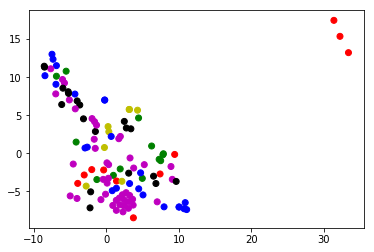

In [33]:
color = ['r', 'b', 'g', 'k', 'y', 'm']


ob_feature_real = obesity_train[:, :900]

sub_model = TSNE(learning_rate=200, n_components=2)
transformed = sub_model.fit_transform(ob_feature_real)

xs = transformed[:,0]
ys = transformed[:,1]
#zs = transformed[:,2]

fig = plt.figure()
ax = fig.add_subplot(111)

color_list = [color[y] for y in obesity_train_y[:, 0]]

plt.scatter(xs,ys,c=color_list)

plt.show()


# For 3D graph
#plt.scatter(xs,zs,c=color_list)

#plt.show()

#plt.scatter(ys,zs,c=color_list)

#plt.show()

# scatter_data = [xs, ys, zs, obesity_train_y[:, 0]]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for index in range(len(scatter_data[0])):
#     ax.scatter(scatter_data[0][index], scatter_data[1][index], scatter_data[2][index], c=color[scatter_data[3][index]])

# plt.show()

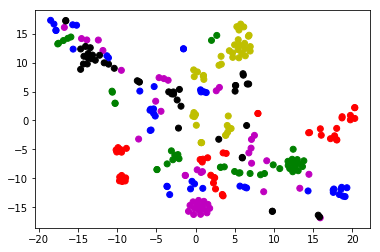

In [34]:
#ob_feature_real = obesity_train[:, :900]
ob_feature_fake = ob_train_res

#sub_model = TSNE(learning_rate=200, n_components=2)
transformed = sub_model.fit_transform(ob_feature_fake)

xs = transformed[:,0]
ys = transformed[:,1]
#zs = transformed[:,2]

fig = plt.figure()
ax = fig.add_subplot(111)

color_list = [color[y] for y in ob_train_y_res]

plt.scatter(xs,ys,c=color_list)

plt.show()


### 중분류(Test Set 15개ㅠㅠ) 
- 데이터가 너무 적어서 학습 많이 할 수록 오버피팅 정도가 심한 듯
- 대분류, 중분류 나누는게 나을지 그냥이 나을지 고민 해봐야할 듯(사실 데이터가 너무 적어서 나눌 수 있을지 의문;; 근데 너무 성능이 안나옴)

In [35]:
y_one_hot = np.eye(6)[ob_train_y_res]
test_y_one_hot = np.eye(6)[obesitiy_val_y[:, 0] -1]

train_epochs = 10000
keep_prob = tf.placeholder(tf.float32)
feature = tf.placeholder(tf.float32, [None, 900])
label = tf.placeholder(tf.int32, [None, 6])


OB_W1 = tf.get_variable('OB_W1', shape=[900, 512], initializer=tf.contrib.layers.xavier_initializer())
# OB_W1 = tf.Variable(tf.random_normal([900, 512]))
OB_B = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(feature, OB_W1) + OB_B)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


OB_W2 = tf.get_variable('OB_W2', shape=[512, 256], initializer=tf.contrib.layers.xavier_initializer())
# OB_W2 = tf.Variable(tf.random_normal([512, 256]))
OB_B2 = tf.Variable(tf.random_normal([256]))
L2 = tf.nn.relu(tf.matmul(L1, OB_W2) + OB_B2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)


OB_W3 = tf.get_variable('OB_W3', shape=[256, 32], initializer=tf.contrib.layers.xavier_initializer())
# OB_W3 = tf.Variable(tf.random_normal([256, 32]))
OB_B3 = tf.Variable(tf.random_normal([32]))
L3 = tf.nn.relu(tf.matmul(L2, OB_W3) + OB_B3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


OB_W4 = tf.get_variable('OB_W4', shape=[32, 6], initializer=tf.contrib.layers.xavier_initializer())
# OB_W4 = tf.Variable(tf.random_normal([32, 6]))
OB_B4 = tf.Variable(tf.random_normal([6]))
#L4 = tf.nn.relu(tf.matmul(feature, OB_W1) + OB_B4)

#hypo = tf.nn.relu(tf.add(tf.matmul(feature, OB_W1), OB_B))
hypo = tf.matmul(L3, OB_W4) + OB_B4
# hypo = tf.add(tf.matmul(), B)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypo, labels=label))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
prediction = tf.argmax(hypo, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
with tf.Session() as sess:
#     sess.run(init)
    sess.run(tf.initialize_all_variables())

    for step in range(1000):
        sess.run(optimizer, feed_dict={feature: ob_feature_fake, label: y_one_hot, keep_prob:0.7})
        if step % 50 == 0: # Test Accuracy 찍어보기!
            loss, acc = sess.run([cost, accuracy], feed_dict={feature: ob_feature_fake, label: y_one_hot, keep_prob:0.7})
            pred_val = sess.run(prediction, feed_dict={feature: obesity_val, keep_prob: 1})
            test_acc = round(sum(pred_val == obesitiy_val_y.flatten())/len(pred_val), 2)
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}\tTest ACC: {:%}".format(
                step, loss, acc, test_acc))

    # Let's see if we can predict
    pred = sess.run(prediction, feed_dict={feature: obesity_val, keep_prob:1})
    # y_data: (N,1) = flatten => (N, ) matches pred.shape
    total_cnt = 0
    right_cnt = 0
    for p, y in zip(pred, obesitiy_val_y):
        total_cnt+=1
        if p == int(y):
            right_cnt+=1
        print("[{}] Prediction: {} True Y: {}".format(p == int(y), p, int(y)))

print('Accuracy :', round(right_cnt/total_cnt, 3))

Step:     0	Loss: 20.134	Acc: 19.32%	Test ACC: 20.000000%
Step:    50	Loss: 1.937	Acc: 51.14%	Test ACC: 47.000000%
Step:   100	Loss: 1.291	Acc: 60.98%	Test ACC: 57.000000%
Step:   150	Loss: 1.081	Acc: 62.88%	Test ACC: 60.000000%
Step:   200	Loss: 0.812	Acc: 77.27%	Test ACC: 57.000000%
Step:   250	Loss: 0.472	Acc: 85.98%	Test ACC: 63.000000%
Step:   300	Loss: 0.390	Acc: 88.26%	Test ACC: 63.000000%
Step:   350	Loss: 0.248	Acc: 92.80%	Test ACC: 67.000000%
Step:   400	Loss: 0.173	Acc: 95.08%	Test ACC: 67.000000%
Step:   450	Loss: 0.111	Acc: 96.21%	Test ACC: 67.000000%
Step:   500	Loss: 0.102	Acc: 96.59%	Test ACC: 67.000000%
Step:   550	Loss: 0.128	Acc: 97.73%	Test ACC: 67.000000%
Step:   600	Loss: 0.093	Acc: 97.35%	Test ACC: 67.000000%
Step:   650	Loss: 0.112	Acc: 98.48%	Test ACC: 67.000000%
Step:   700	Loss: 0.186	Acc: 97.73%	Test ACC: 67.000000%
Step:   750	Loss: 0.106	Acc: 96.97%	Test ACC: 67.000000%
Step:   800	Loss: 0.042	Acc: 98.86%	Test ACC: 67.000000%
Step:   850	Loss: 0.057	Acc: 9

### Ship 중분류
- AAA, AAB --> AA
- ABA, ABB --> AB 이런 형식으로 바꿔야 함

In [103]:
ship_text['subclass'] = ship_text['subclass'].str[:2]

,title,claim,abstract,class,subclass
patent_id,,,,,
6186085,"[2.1553414314985275, 3.817645624279976, -3.262...","[14.435036703944206, -2.9458367256447673, -32....","[8.600283816456795, 3.7816136153414845, -25.98...",3,AA
6213041,"[0.6455068569630384, 0.43396481219679117, -0.8...","[1.6431635057087988, 7.356814027763903, -50.23...","[-0.9945224525872618, -3.7941296761855483, -25...",3,AA
6273769,"[0.4783546063117683, 0.9346346501260996, -5.47...","[13.315646646544337, 4.6950280405581, -32.0013...","[3.3055048314854503, 0.009314091876149178, -11...",3,AA
6299496,"[-0.37274372670799494, 0.33574831672012806, 0....","[31.751632682047784, -20.188554668799043, -49....","[-0.00622390815988183, -1.90272843465209, -8.0...",3,AA
6408777,"[-0.630397074855864, -0.08248244784772396, -0....","[13.7503782492131, -9.868930844590068, -31.039...","[12.784004948567599, -0.8214465277269483, -32....",3,AA
6415209,"[-0.5406816452741623, 0.017014912329614162, -1...","[-5.7075521890074015, -12.80785275483504, -53....","[-5.8917351216077805, -5.38080508261919, -18.1...",3,AA
6458003,"[0.5163082759827375, 0.11969582550227642, -1.1...","[5.955199320800602, 5.610137527808547, -17.319...","[19.423374274745584, 9.281917328131385, -43.79...",3,AA
6571722,"[0.9859462957829237, 0.30098357796669006, -0.5...","[-6.5747233014553785, -12.762464872561395, -36...","[2.9955960852093995, -0.7927042283117771, -30....",3,AA
6571722,"[0.9859462957829237, 0.30098357796669006, -0.5...","[-6.5747233014553785, -12.762464872561395, -36...","[2.9955960852093995, -0.7927042283117771, -30....",3,AB


In [104]:
sh_subclass_vec = np.array(ship_text['subclass']).reshape(-1, 1)
le.fit(np.unique(sh_subclass_vec))
sh_subclass = le.transform(sh_subclass_vec)
sh_subclass = sh_subclass.reshape(-1, 1)

/Users/jinhong/miniconda3/envs/patent/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [109]:
ship_train, ship_val, ship_train_y, ship_val_y = train_test_split(sh_feature_vec, sh_subclass,
                                                  test_size = .2,
                                                  random_state=12)

In [127]:
mid_sm = SMOTE(random_state=12, ratio = 1.0, k_neighbors=3)
sh_train_res, sh_train_y_res =mid_sm.fit_sample(ship_train, ship_train_y)

/Users/jinhong/miniconda3/envs/patent/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jinhong/miniconda3/envs/patent/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


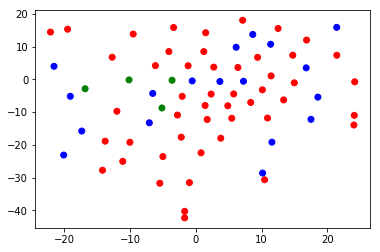

In [128]:
color = ['r', 'b', 'g']#, 'k', 'y', 'm']


sh_feature_real = ship_train[:, :900]

sub_model = TSNE(learning_rate=200, n_components=2)
transformed = sub_model.fit_transform(sh_feature_real)

xs = transformed[:,0]
ys = transformed[:,1]
#zs = transformed[:,2]

fig = plt.figure()
ax = fig.add_subplot(111)

color_list = [color[y] for y in ship_train_y[:, 0]]

plt.scatter(xs,ys,c=color_list)

plt.show()

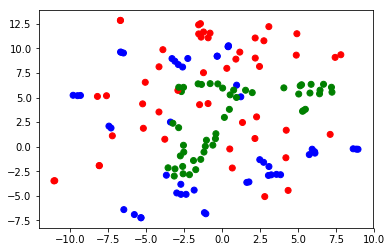

In [129]:
#ob_feature_real = obesity_train[:, :900]
sh_feature_fake = sh_train_res

#sub_model = TSNE(learning_rate=200, n_components=2)
transformed = sub_model.fit_transform(sh_feature_fake)

xs = transformed[:,0]
ys = transformed[:,1]
#zs = transformed[:,2]

fig = plt.figure()
ax = fig.add_subplot(111)

color_list = [color[y] for y in sh_train_y_res]

plt.scatter(xs,ys,c=color_list)

plt.show()


In [130]:
y_one_hot = np.eye(3)[sh_train_y_res]
test_y_one_hot = np.eye(3)[ship_val_y[:, 0] -1]

train_epochs = 10000
keep_prob = tf.placeholder(tf.float32)
feature = tf.placeholder(tf.float32, [None, 900])
label = tf.placeholder(tf.int32, [None, 3])


SH_W1 = tf.get_variable('SH_W1', shape=[900, 512], initializer=tf.contrib.layers.xavier_initializer())
# SH_W1 = tf.Variable(tf.random_normal([900, 512]))
SH_B = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(feature, SH_W1) + SH_B)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


SH_W2 = tf.get_variable('SH_W2', shape=[512, 256], initializer=tf.contrib.layers.xavier_initializer())
# SH_W2 = tf.Variable(tf.random_normal([512, 256]))
SH_B2 = tf.Variable(tf.random_normal([256]))
L2 = tf.nn.relu(tf.matmul(L1, SH_W2) + SH_B2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)


SH_W3 = tf.get_variable('SH_W3', shape=[256, 32], initializer=tf.contrib.layers.xavier_initializer())
# SH_W3 = tf.Variable(tf.random_normal([256, 32]))
SH_B3 = tf.Variable(tf.random_normal([32]))
L3 = tf.nn.relu(tf.matmul(L2, SH_W3) + SH_B3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


SH_W4 = tf.get_variable('SH_W4', shape=[32, 3], initializer=tf.contrib.layers.xavier_initializer())
# SH_W4 = tf.Variable(tf.random_normal([32, 6]))
SH_B4 = tf.Variable(tf.random_normal([3]))
#L4 = tf.nn.relu(tf.matmul(feature, SH_W1) + SH_B4)

#hypo = tf.nn.relu(tf.add(tf.matmul(feature, SH_W1), SH_B))
hypo = tf.matmul(L3, SH_W4) + SH_B4
# hypo = tf.add(tf.matmul(), B)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypo, labels=label))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
prediction = tf.argmax(hypo, 1)
correct_prediction = tf.equal(prediction, tf.argmax(y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [131]:
with tf.Session() as sess:
#     sess.run(init)
    sess.run(tf.initialize_all_variables())

    for step in range(1000):
        sess.run(optimizer, feed_dict={feature: sh_feature_fake, label: y_one_hot, keep_prob:0.7})
        if step % 50 == 0: # Test Accuracy 찍어보기!
            loss, acc = sess.run([cost, accuracy], feed_dict={feature: sh_feature_fake, label: y_one_hot, keep_prob:0.7})
            pred_val = sess.run(prediction, feed_dict={feature: ship_val, keep_prob: 1})
            test_acc = round(sum(pred_val == ship_val_y.flatten())/len(pred_val), 2)
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}\tTest ACC: {:%}".format(
                step, loss, acc, test_acc))

    # Let's see if we can predict
    pred = sess.run(prediction, feed_dict={feature: ship_val, keep_prob:1})
    # y_data: (N,1) = flatten => (N, ) matches pred.shape
    total_cnt = 0
    right_cnt = 0
    for p, y in zip(pred, ship_val_y):
        total_cnt+=1
        if p == int(y):
            right_cnt+=1
        print("[{}] Prediction: {} True Y: {}".format(p == int(y), p, int(y)))

print('Accuracy :', round(right_cnt/total_cnt, 3))

Step:     0	Loss: 10.673	Acc: 27.89%	Test ACC: 28.000000%
Step:    50	Loss: 0.889	Acc: 69.39%	Test ACC: 61.000000%
Step:   100	Loss: 0.382	Acc: 91.16%	Test ACC: 56.000000%
Step:   150	Loss: 0.396	Acc: 84.35%	Test ACC: 61.000000%
Step:   200	Loss: 0.212	Acc: 94.56%	Test ACC: 61.000000%
Step:   250	Loss: 0.208	Acc: 94.56%	Test ACC: 61.000000%
Step:   300	Loss: 0.181	Acc: 92.52%	Test ACC: 61.000000%
Step:   350	Loss: 0.146	Acc: 95.92%	Test ACC: 61.000000%
Step:   400	Loss: 0.096	Acc: 97.96%	Test ACC: 61.000000%
Step:   450	Loss: 0.102	Acc: 96.60%	Test ACC: 61.000000%
Step:   500	Loss: 0.099	Acc: 95.92%	Test ACC: 61.000000%
Step:   550	Loss: 0.090	Acc: 97.28%	Test ACC: 61.000000%
Step:   600	Loss: 0.129	Acc: 94.56%	Test ACC: 61.000000%
Step:   650	Loss: 0.091	Acc: 97.28%	Test ACC: 61.000000%
Step:   700	Loss: 0.052	Acc: 98.64%	Test ACC: 61.000000%
Step:   750	Loss: 0.087	Acc: 96.60%	Test ACC: 61.000000%
Step:   800	Loss: 0.103	Acc: 95.92%	Test ACC: 61.000000%
Step:   850	Loss: 0.075	Acc: 9